In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

random.seed(0)
np.random.seed(0)

In [2]:
data = pd.read_csv('data.txt',header=None,names=['x','y'],delim_whitespace=True)

In [3]:
data.head()

,x,y
0,-6.0,-164.160590
1,-5.8,90.739607
2,-5.6,-131.842090
3,-5.4,-178.428200
4,-5.2,-4.838565


<AxesSubplot:xlabel='x', ylabel='y'>

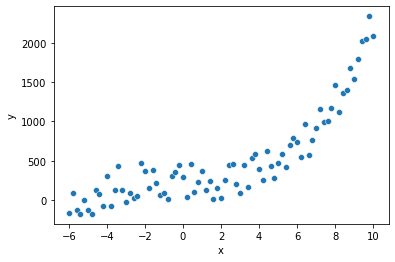

In [4]:
sns.scatterplot(x='x',y='y',data=data)

In [5]:
from sklearn.model_selection import KFold

In [6]:
X=data['x'].to_numpy()
Y=data['y'].to_numpy()
kfold = KFold(n_splits=10)
trainX=[]
trainY=[]
testX=[]
testY=[]

In [7]:
for train_index, test_index in kfold.split(X):
    trainX.append(X[train_index])
    testX.append(X[test_index])
    trainY.append(Y[train_index])
    testY.append(Y[test_index])

In [23]:
stdTrainX=[]
stdTestX=[]
stdTrainY=[]
stdTestY=[]
for i in range(10):
    stdTrainX.append((trainX[i]-np.mean(trainX[i],axis=0))/np.std(trainX[i],axis=0))
    stdTrainY.append((trainY[i]-np.mean(trainY[i],axis=0))/np.std(trainY[i],axis=0))
    stdTestX.append((testX[i]-np.mean(testX[i],axis=0))/np.std(testX[i],axis=0))
    stdTestY.append((testY[i]-np.mean(testY[i],axis=0))/np.std(testY[i],axis=0))

In [31]:
from sklearn.linear_model import SGDRegressor,LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [16]:
def computeCost(X,y,weights):
    n = len(y);
    predictions = X.dot(weights)
    sq_err = (predictions-y)**2;
    return np.mean(sq_err)

In [17]:
def computeStdCost(X,y,weights):
    n = len(y);
    predictions = X.dot(weights)
    sq_err = (predictions-y)**2;
    return np.std(sq_err)

In [58]:
def computeModels(degree):
    model_weights=[]
    for ind in range(10):
        polyFeat = PolynomialFeatures(degree=degree)
        Xtrain = polyFeat.fit_transform(stdTrainX[ind].reshape(-1,1))
        cmodel = SGDRegressor(max_iter=1500)
        cmodel.fit(Xtrain,stdTrainY[ind])
        weight=[]
        for item in (cmodel.coef_):
            weight.append(item)
        model_weights.append(weight)
    return model_weights

In [126]:
def computeErrorTerms(degree,nthModel,weight_list):
    polyFeat = PolynomialFeatures(degree=degree)
    modelNo = nthModel+1
    label = 'hypothesis'+str(modelNo)
    title = 'Hypothesis'+str(modelNo)
    plt.figure(figsize=(12,8))
    train_mean_err_list=[]
    test_mean_err_list=[]
    train_std_err_list=[]
    test_std_err_list=[]
    
    train_mean_y=[]
    test_mean_y=[]
    train_std_y=[]
    test_std_y=[]
    
    for i in range(10):
        weights = np.array(weight_list[i]).reshape((degree+1,1))
        Xtrain = polyFeat.fit_transform(stdTrainX[i].reshape(-1,1))
        Xtest = polyFeat.transform(stdTestX[i].reshape(-1,1))
        
        train_err = computeCost(Xtrain,stdTrainY[i].reshape(len(stdTrainY[i]),1),weights)
        test_err = computeCost(Xtest,stdTestY[i].reshape(len(stdTestY[i]),1),weights)
        train_std_err = computeStdCost(Xtrain,stdTrainY[i].reshape(len(stdTrainY[i]),1),weights)
        test_std_err = computeCost(Xtest,stdTestY[i].reshape(len(stdTestY[i]),1),weights)
        
        train_mean_y.append(np.mean(stdTrainY[i],axis=0))
        test_mean_y.append(np.mean(stdTestY[i],axis=0))
        train_std_y.append(np.std(stdTrainY[i],axis=0))
        test_std_y.append(np.std(stdTestY[i],axis=0))
        
        train_mean_err_list.append(train_err)
        test_mean_err_list.append(test_err)
        train_std_err_list.append(train_std_err/np.sqrt(10))
        test_std_err_list.append(test_std_err/np.sqrt(10))
        
        print("mean train error : ",train_err)
        print("std train error : ",train_std_err)
        print("mean test error : ",test_err)
        print("std test error : ",test_std_err)
        print("\n")
      
    print("\n\n")
    ind=[1,2,3,4,5,6,7,8,9,10]
    plt.subplot(2,2,1)
    plt.errorbar(x=ind,y=train_mean_y,yerr=train_mean_err_list, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=10)
    plt.xlabel(label)
    plt.ylabel('train mean errorbar')
    plt.subplot(2,2,2)
    plt.errorbar(x=ind,y=train_std_y,yerr=train_std_err_list, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
    plt.xlabel(label)
    plt.ylabel('train std errorbar')
    plt.subplot(2,2,3)
    plt.errorbar(x=ind,y=test_mean_y,yerr=test_mean_err_list, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
    plt.xlabel(label)
    plt.ylabel('test mean errorbar')
    plt.subplot(2,2,4)
    plt.errorbar(x=ind,y=test_std_y,yerr=test_std_err_list,fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
    plt.ylabel('test std errorbar')
    plt.suptitle(title)
    plt.show()

    min_val = min(train_mean_err_list)
    min_ind = train_mean_err_list.index(min_val)
    print("min training error ",min_val," at index",min_ind+1,"for Hypothesis ",modelNo)
    plt.scatter(stdTrainX[min_ind],stdTrainY[min_ind])
    X_Poly = polyFeat.fit_transform(stdTrainX[min_ind].reshape(-1,1))
    pred = X_Poly.dot(np.array(weight_list[min_ind]).reshape(degree+1,1))
    plt.plot(stdTrainX[min_ind],pred,'r')
    

In [128]:
weight_list = computeModels(1)
print(weight_list)

[[0.0005141230004085904, 0.7798046317108427], [0.0017215914787900098, 0.7937831835501783], [0.0008519232152699544, 0.7967948562156134], [-0.0004802003834431471, 0.7888361559757987], [2.821124739787832e-05, 0.8069750772401904], [0.0007888906145012143, 0.8084933271282508], [-6.551361110695907e-05, 0.8174077744454434], [-0.0006495224348673797, 0.8103432093044936], [0.00016789812605395952, 0.7689541456993837], [0.0013757614709410696, 0.7814841780446772]]


mean train error :  0.3193563846826335
std train error :  0.499758394358747
mean test error :  1.0313830434241344
std test error :  1.0313830434241344


mean train error :  0.2998761352657292
std train error :  0.49365004434850285
mean test error :  1.4848884165534804
std test error :  1.4848884165534804


mean train error :  0.3003565448732763
std train error :  0.4954915470502629
mean test error :  1.4426932164507162
std test error :  1.4426932164507162


mean train error :  0.30460949050508307
std train error :  0.5025523068395702
mean test error :  0.908853651493033
std test error :  0.908853651493033


mean train error :  0.2830611357906615
std train error :  0.4843781778123412
mean test error :  2.393010708315925
std test error :  2.393010708315925


mean train error :  0.27409048320533846
std train error :  0.45687068802465586
mean test error :  1.5270763284744113
std test error :  1.5270763284744113


mean train error :  0.26445076747590074
std train error :  0.4307756566845839

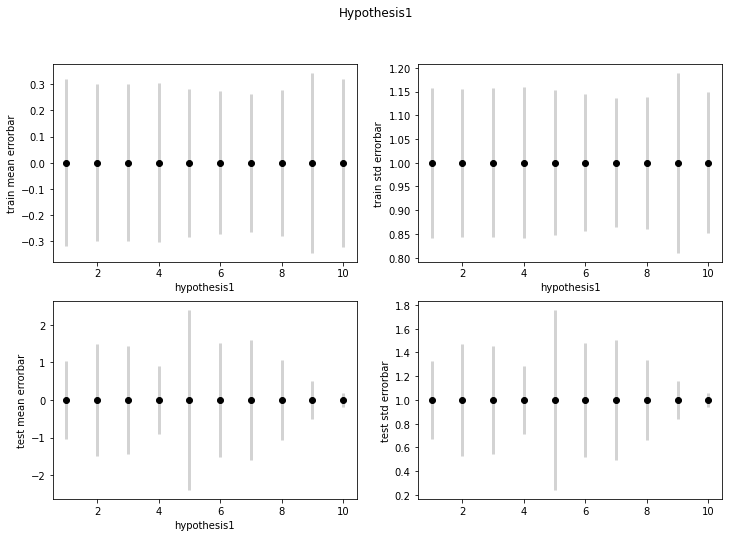

min training error  0.26445076747590074  at index 7 for Hypothesis  1


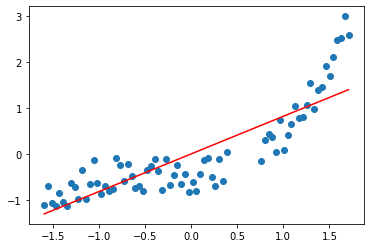

In [125]:
computeErrorTerms(1,0,weight_list)

In [111]:
weight_list = computeModels(3)
print(weight_list)

[[-0.19076197903805803, 0.23089333008507357, 0.41051970503647695, 0.32117938067692253], [-0.18546249220804217, 0.2798630966191677, 0.46863988326523304, 0.3155937449402401], [-0.17540012510078937, 0.2598667045553163, 0.4535421272544519, 0.35544167725296427], [-0.1678210807843877, 0.22944464962405245, 0.4218356355807777, 0.38211777868821595], [-0.1534343178055925, 0.21894085838636185, 0.35748320630991487, 0.3934484205874206], [-0.1679239512590432, 0.21163786993040978, 0.34542027412529946, 0.377523889676709], [-0.1633641466914365, 0.17955364238284877, 0.2993950338524044, 0.366391437424703], [-0.15303451423830108, 0.14618468176074045, 0.2600177465276725, 0.3416095450827849], [-0.13603549135359808, 0.09664275713647945, 0.23364265770774822, 0.33446324923899434], [-0.10895312922534763, 0.18272473257629537, 0.24598039921627965, 0.34983330363365855]]


mean train error :  0.12764226725672867
std train error :  0.14223174282396994
mean test error :  0.8853583942390457
std test error :  0.8853583942390457


mean train error :  0.11437259556654966
std train error :  0.12843928829878598
mean test error :  2.1613940131882257
std test error :  2.1613940131882257


mean train error :  0.10896196265907947
std train error :  0.12129684647701322
mean test error :  2.3994843258044387
std test error :  2.3994843258044387


mean train error :  0.10811429530132048
std train error :  0.11649771936754451
mean test error :  1.3455110567044533
std test error :  1.3455110567044533


mean train error :  0.10645498111862557
std train error :  0.1219239277289892
mean test error :  2.923751458583473
std test error :  2.923751458583473


mean train error :  0.10797744843842594
std train error :  0.11651655949478894
mean test error :  1.331211588048736
std test error :  1.331211588048736


mean train error :  0.1048570616343422
std train error :  0.115065476

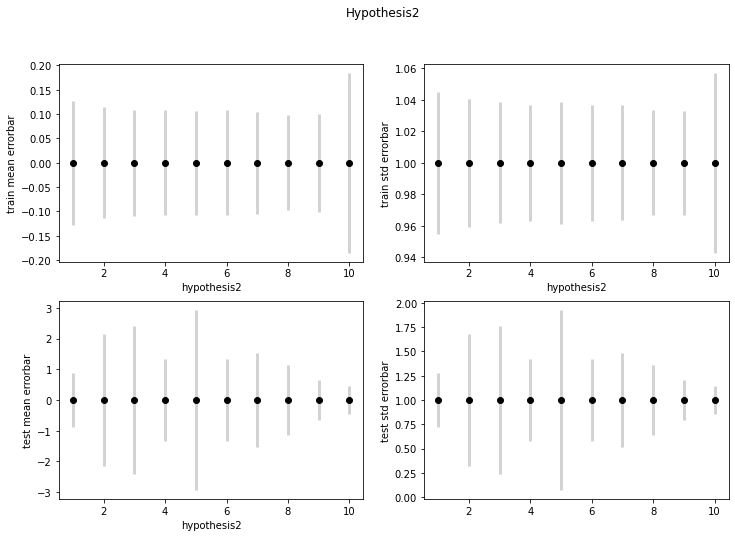

min training error  0.09699765830439977  at index 8 for Hypothesis  2


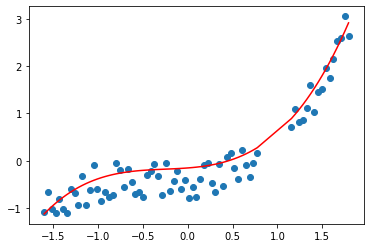

In [112]:
computeErrorTerms(3,1,weight_list)

In [113]:
weight_list = computeModels(5)
print(weight_list)

[[-0.1679950625937623, 0.2600881920046095, 0.06325590919517643, 0.1949533347139535, 0.16300032253172564, 0.04501327212514822], [-0.16449039708492022, 0.2877608549475095, 0.07852739486718928, 0.2509983230732296, 0.16714232408379456, 0.03692813569133573], [-0.1587449175597392, 0.26055130124179343, 0.08552488145343581, 0.2209659307390704, 0.19441608782951944, 0.0629320284540533], [-0.15719141886121524, 0.2472971731755117, 0.07383448408989075, 0.21709742617581534, 0.18831691960468408, 0.07530813368496413], [-0.1489939618319572, 0.2370136433415658, 0.038268501077363244, 0.21014348974865735, 0.17841909146754398, 0.08957740964000076], [-0.1609052939579256, 0.23329900352091018, 0.06394325473997652, 0.18691046715381665, 0.1501583101419979, 0.07114666390667937], [-0.16929196242516456, 0.23033424111984346, 0.07418482268757658, 0.19497237887167349, 0.1260588625729357, 0.05143866608083362], [-0.14753457396599132, 0.16196280257413817, 0.037678256822561255, 0.15284078788403033, 0.10504652192250116, 0

mean train error :  0.12056011675892636
std train error :  0.1477879664031342
mean test error :  0.9151157688011623
std test error :  0.9151157688011623


mean train error :  0.09639969521569276
std train error :  0.1150100175540655
mean test error :  2.172079111537663
std test error :  2.172079111537663


mean train error :  0.11062409178971244
std train error :  0.12669135174835702
mean test error :  2.651863443808736
std test error :  2.651863443808736


mean train error :  0.10149708642152383
std train error :  0.11709057666235623
mean test error :  1.3382457477988186
std test error :  1.3382457477988186


mean train error :  0.09341868049829047
std train error :  0.11868450652298643
mean test error :  3.1940276571359725
std test error :  3.1940276571359725


mean train error :  0.09822696365411573
std train error :  0.10999734441394021
mean test error :  1.2598085305243576
std test error :  1.2598085305243576


mean train error :  0.09767627984689148
std train error :  0.107869968

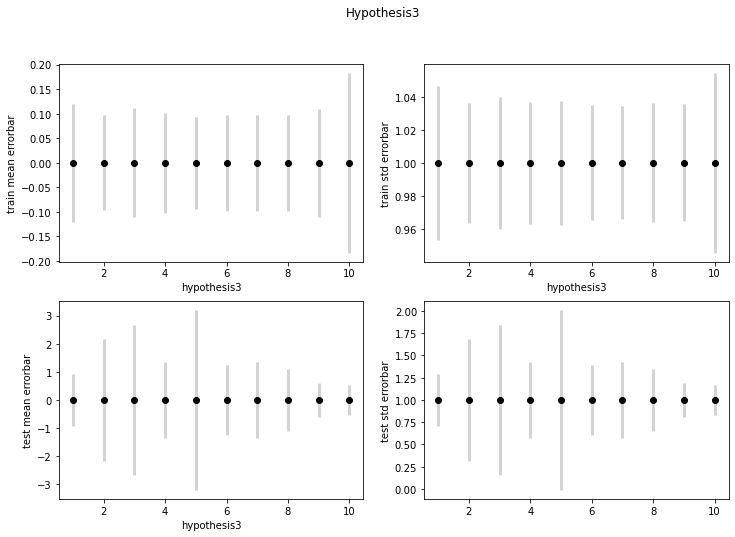

min training error  0.09341868049829047  at index 5 for Hypothesis  3


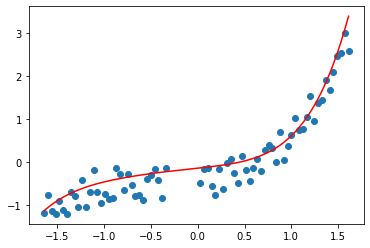

In [114]:
computeErrorTerms(5,2,weight_list)

In [115]:
weight_list = computeModels(50)
print(weight_list)

[[259934767.8272888, 108466330527.63402, -5926303707.742498, 206529288387.713, -11229037322.057446, 407260013617.494, -7649392776.335736, 889905715162.0718, 31307699194.903088, 2088417169936.9404, 184587145881.42813, 5113906591950.178, 676605661816.9387, 12845281274861.988, 2124465685991.3516, 32788230744331.52, 6185849679490.047, 84598063123073.34, 17237649090149.592, 219915495715380.3, 46683217808943.84, 574733230252702.6, 123911038420247.48, 1507719309137492.8, 323960202684202.6, 3965554500925635.0, 836846268451998.2, 1.044715794812612e+16, 2140006997330302.2, 2.75451103392055e+16, 5424016860156461.0, 7.263073599851115e+16, 1.3635119436222558e+16, 1.9139150644202413e+17, 3.4005934881385816e+16, 5.0367869448063123e+17, 8.413836749410333e+16, 1.3228451096318333e+18, 2.0645985608825382e+17, 3.464698039466353e+18, 5.0212296548506035e+17, 9.04201888767423e+18, 1.209222935436095e+18, 2.3490903675388314e+19, 2.879661800756203e+18, 6.068520067274383e+19, 6.768736854319385e+18, 1.55674925879

mean train error :  3.8922874372726983e+62
std train error :  2.262548878607981e+63
mean test error :  2.168280419319938e+59
std test error :  2.168280419319938e+59


mean train error :  8.508151068564684e+71
std train error :  6.542917294932561e+72
mean test error :  4.0996877958426645e+63
std test error :  4.0996877958426645e+63


mean train error :  3.4783272440657726e+64
std train error :  2.7000938060377617e+65
mean test error :  5.26790200933076e+58
std test error :  5.26790200933076e+58


mean train error :  2.0249032316803106e+62
std train error :  1.5704813913392781e+63
mean test error :  5.820047623795035e+58
std test error :  5.820047623795035e+58


mean train error :  1.3556634669477097e+60
std train error :  1.0124158136747272e+61
mean test error :  1.0502908711134975e+58
std test error :  1.0502908711134975e+58


mean train error :  4.6860675516371545e+58
std train error :  3.4255915919468963e+59
mean test error :  3.3819094527496604e+56
std test error :  3.38190945274966

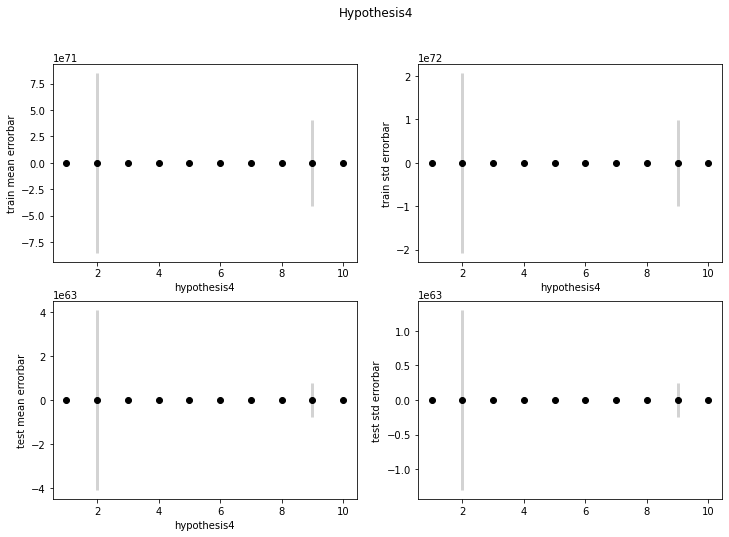

min training error  4.6860675516371545e+58  at index 6 for Hypothesis  4


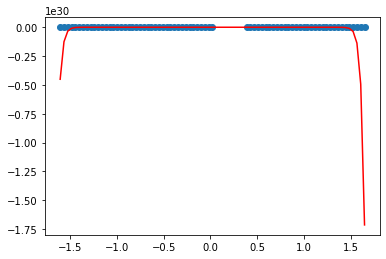

In [116]:
computeErrorTerms(50,3,weight_list)